In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=6407b42ce431c25eb6d98ddfe1e456e1406ba0f035da8fe568d95fcb732baf95
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master("local") \
        .appName("Google Drive and PySpark") \
        .getOrCreate()

In [4]:
file_path = '/content/drive/MyDrive/iotmdf/Parking_Violations_Issued_-_Fiscal_Year_2020.csv'

df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv(file_path)


In [5]:
df.show(10)
num=len(df.columns)

print(num)

+--------------+--------+------------------+----------+--------------------+--------------+-----------------+------------+--------------+------------+------------+------------+-----------------------+------------------+------------------+---------------+-----------+--------------+------------+--------------+-------------------+----------------+---------------------------------+------------+-------------------+-------------------+-------------------+-----------+------------+--------------------+----------------------+--------------------+------------------+-------------+---------------------+------------+------------+--------------+-------------------+---------------------+---------------------------------+-----------------+------------------------+
|Summons Number|Plate ID|Registration State|Plate Type|          Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Issuing Agency|Street Code1|Street Code2|Street Code3|Vehicle Expiration Date|Violation Location|Violation Precinct|Iss

In [6]:
limited_df = df.limit(100000)

In [119]:
num_rows = df.count()
print("Number of rows: ", num_rows)

numy=limited_df.count()
print("Number of limited df: ", numy)

Number of rows:  12495734
Number of limited df:  100000


In [120]:
from pyspark.sql.types import StringType

In [122]:

dtypes = df.dtypes


print(dtypes)

[('Summons Number', 'bigint'), ('Plate ID', 'string'), ('Registration State', 'string'), ('Plate Type', 'string'), ('Issue Date', 'string'), ('Violation Code', 'int'), ('Vehicle Body Type', 'string'), ('Vehicle Make', 'string'), ('Issuing Agency', 'string'), ('Street Code1', 'int'), ('Street Code2', 'int'), ('Street Code3', 'int'), ('Vehicle Expiration Date', 'int'), ('Violation Location', 'int'), ('Violation Precinct', 'int'), ('Issuer Precinct', 'int'), ('Issuer Code', 'int'), ('Issuer Command', 'string'), ('Issuer Squad', 'string'), ('Violation Time', 'string'), ('Time First Observed', 'string'), ('Violation County', 'string'), ('Violation In Front Of Or Opposite', 'string'), ('House Number', 'string'), ('Street Name', 'string'), ('Intersecting Street', 'string'), ('Date First Observed', 'int'), ('Law Section', 'int'), ('Sub Division', 'string'), ('Violation Legal Code', 'string'), ('Days Parking In Effect', 'string'), ('From Hours In Effect', 'string'), ('To Hours In Effect', 'stri

In [123]:


columns_to_keep = ["Registration State", "Plate Type", "Street Code1","Street Code2","Street Code3","Violation Code","Issue Date","Vehicle Body Type","Vehicle Color","Violation Precinct","Violation Time","Violation County"]

new_df = limited_df.select(*columns_to_keep)

numy=len(new_df.columns)

new_df.show()
print(numy)

+------------------+----------+------------+------------+------------+--------------+--------------------+-----------------+-------------+------------------+--------------+----------------+
|Registration State|Plate Type|Street Code1|Street Code2|Street Code3|Violation Code|          Issue Date|Vehicle Body Type|Vehicle Color|Violation Precinct|Violation Time|Violation County|
+------------------+----------+------------+------------+------------+--------------+--------------------+-----------------+-------------+------------------+--------------+----------------+
|                NJ|       PAS|        8730|        5130|        5280|            16|05/08/1972 12:00:...|              SDN|           BK|                72|         0523P|               K|
|                PA|       PAS|       86530|       71800|       73110|            98|08/29/1977 12:00:...|             SUBN|          BLK|                77|         0428P|               K|
|                NJ|       PAS|       27030|      

In [97]:
df_cleaned = new_df.na.drop()

df_cleaned.show()

+------------------+----------+------------+------------+------------+--------------+--------------------+-----------------+-------------+------------------+--------------+----------------+
|Registration State|Plate Type|Street Code1|Street Code2|Street Code3|Violation Code|          Issue Date|Vehicle Body Type|Vehicle Color|Violation Precinct|Violation Time|Violation County|
+------------------+----------+------------+------------+------------+--------------+--------------------+-----------------+-------------+------------------+--------------+----------------+
|                NJ|       PAS|        8730|        5130|        5280|            16|05/08/1972 12:00:...|              SDN|           BK|                72|         0523P|               K|
|                PA|       PAS|       86530|       71800|       73110|            98|08/29/1977 12:00:...|             SUBN|          BLK|                77|         0428P|               K|
|                NJ|       PAS|       27030|      

In [115]:
num_rows=df_cleaned.count()
print(num_rows)

89018


In [124]:
distinct_count = df_cleaned.select("Violation Code").distinct().count()

print(f"The number of distinct values in the 'violation_code' column is: {distinct_count}")

The number of distinct values in the 'violation_code' column is: 35


In [125]:
from pyspark.sql.functions import col, desc


aggregated_data = df_cleaned.groupBy("Violation Code").count()


total_count = aggregated_data.agg({"count": "sum"}).collect()[0][0]


sorted_data = aggregated_data.sort(desc("count"))

threshold = 0.99 * total_count
accumulated_count = 0
codes_responsible_99_percent = []

for row in sorted_data.collect():
    accumulated_count += row["count"]
    codes_responsible_99_percent.append(row["Violation Code"])

    if accumulated_count >= threshold:
        break

num_distinct_codes_99_percent = len(codes_responsible_99_percent)

print(f"Number of distinct violation codes responsible for 99% of the rows: {num_distinct_codes_99_percent}")

Number of distinct violation codes responsible for 99% of the rows: 29


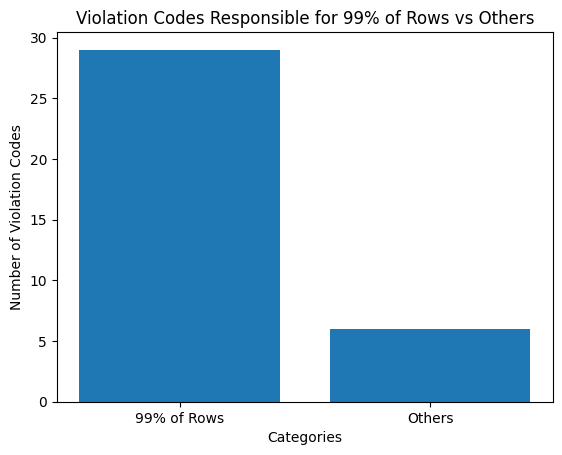

In [126]:
import matplotlib.pyplot as plt

num_distinct_codes_not_99_percent = df_cleaned.select("Violation Code").distinct().count() - num_distinct_codes_99_percent

categories = ['99% of Rows', 'Others']
values = [num_distinct_codes_99_percent, num_distinct_codes_not_99_percent]


plt.bar(categories, values)
plt.xlabel('Categories')
plt.ylabel('Number of Violation Codes')
plt.title('Violation Codes Responsible for 99% of Rows vs Others')
plt.show()


In [132]:
from pyspark.sql.functions import col

df_cleaned = df_cleaned.filter(col("Violation Code").isin(codes_responsible_99_percent))

In [128]:
violation_counts = df_cleaned.groupBy("Violation Code").count().sort("count", ascending=False)
top_violations = violation_counts.take(10)

print(top_violations)


[Row(Violation Code=7, count=25573), Row(Violation Code=5, count=24754), Row(Violation Code=21, count=14343), Row(Violation Code=14, count=4245), Row(Violation Code=36, count=3810), Row(Violation Code=46, count=2793), Row(Violation Code=20, count=1611), Row(Violation Code=40, count=1559), Row(Violation Code=98, count=1172), Row(Violation Code=19, count=1156)]


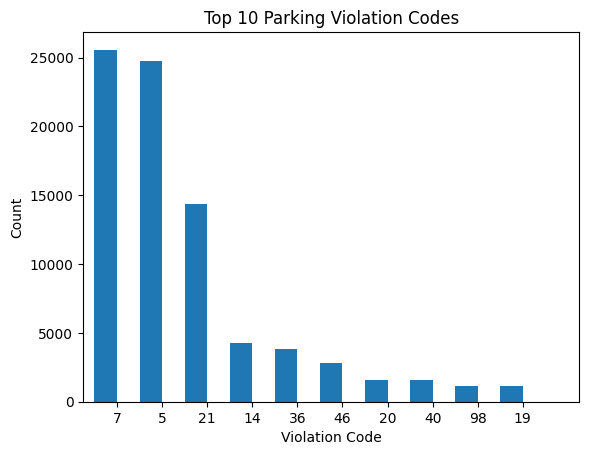

In [133]:

from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("Parking Violations Analysis") \
    .getOrCreate()

    
violation_codes, counts = zip(*[(row["Violation Code"], row["count"]) for row in top_violations])


bar_width = 1 
spacing = 2  
bar_positions = [i * spacing for i in range(len(violation_codes))]
plt.bar(bar_positions, counts, width=bar_width)
plt.xlabel("Violation Code")
plt.ylabel("Count")
plt.title("Top 10 Parking Violation Codes")

tick_positions = [pos + bar_width / 2 for pos in bar_positions]
plt.xticks(tick_positions,violation_codes)

plt.xlim(-bar_width, max(bar_positions) + bar_width + spacing)


plt.show()





In [136]:
from pyspark.sql.functions import to_date, col
date_format = "MM/dd/yyyy"
df_cleaned = df_cleaned.withColumn("Issue Date", to_date(col("Issue Date"), date_format))

df_counts = df_cleaned.groupBy(month("Issue Date").alias("month")).agg(count("*").alias("count"))


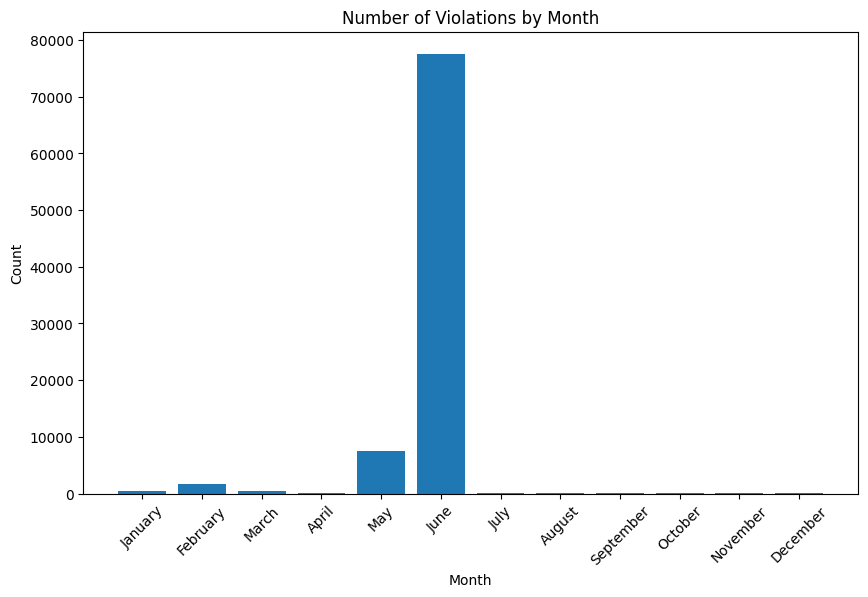

In [137]:
from pyspark.sql.functions import count, month
from pyspark.sql import SparkSession
import calendar

spark = SparkSession.builder.appName("MyApp") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

df_counts = df_cleaned.groupBy(month("Issue Date").alias("month")).agg(count("*").alias("count"))
df_counts = df_counts.sort("month")
df_counts_pd = df_counts.toPandas()
df_counts_pd = df_counts_pd[df_counts_pd["month"].notnull()]
df_counts_pd["month"] = df_counts_pd["month"].astype(int)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Number of Violations by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.bar(df_counts_pd["month"], df_counts_pd["count"])

unique_months = df_counts_pd["month"].unique()
month_labels = [calendar.month_name[month_idx] for month_idx in unique_months]
plt.xticks(unique_months, month_labels, rotation=45)

plt.show()



In [55]:
from pyspark.sql.functions import desc


state_counts = df_cleaned.groupBy('Registration State').count()

state_counts = state_counts.orderBy(desc('count'))


state_counts.show(10)

+------------------+-----+
|Registration State|count|
+------------------+-----+
|                NY|72831|
|                NJ| 7327|
|                FL| 1416|
|                PA| 1323|
|                VA|  753|
|                IN|  543|
|                CT|  516|
|                ME|  500|
|                MA|  374|
|                TX|  271|
+------------------+-----+
only showing top 10 rows



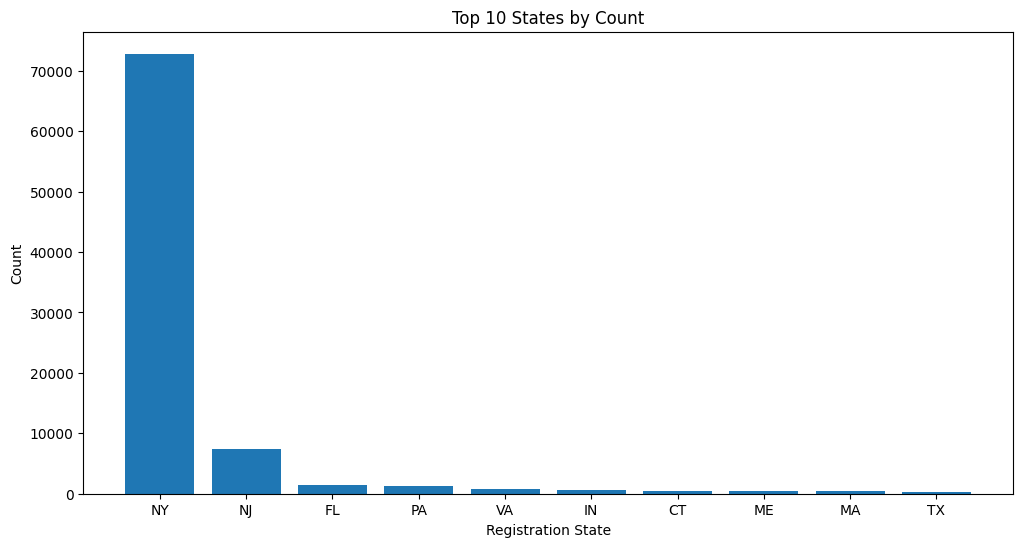

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

state_counts_pd = state_counts.toPandas()


plt.figure(figsize=(12, 6))
plt.bar(state_counts_pd['Registration State'][:10], state_counts_pd['count'][:10])
plt.xlabel('Registration State')
plt.ylabel('Count')
plt.title('Top 10 States by Count')

plt.show()


In [60]:

color_counts = df_cleaned.groupBy('Vehicle Color').count()


top_colors = color_counts.orderBy('count', ascending=False).limit(40)


top_colors.show()



+-------------+-----+
|Vehicle Color|count|
+-------------+-----+
|         grey|20933|
|           BK|16831|
|        white|14481|
|         blue| 5230|
|        WHITE| 3460|
|          red| 3400|
|          BLK| 3238|
|        BLACK| 2363|
|       silver| 2038|
|         BLUE| 1804|
|          RED| 1647|
|          WHT| 1561|
|         GREY| 1328|
|        brown| 1241|
|       yellow| 1145|
|           WT|  931|
|           TN|  818|
|        GREEN|  403|
|        BROWN|  374|
|          TAN|  354|
+-------------+-----+
only showing top 20 rows



In [63]:
from pyspark.sql.functions import regexp_replace, when
from pyspark.sql.functions import lower



df_cleaned = df_cleaned.withColumn('Vehicle Color', when(df_cleaned['Vehicle Color'].isin(['SL', 'SILVR', 'SIL', 'SILVE','sl.']), 'silver')
                                 .otherwise(df_cleaned['Vehicle Color']))


df_cleaned = df_cleaned.withColumn('Vehicle Color', when(df_cleaned['Vehicle Color'].isin(['dark blue', 'BL','blu']), 'blue')
                                 .when(df_cleaned['Vehicle Color'] == 'dark green', 'green')
                                 .when(df_cleaned['Vehicle Color'].isin(['blk', 'bl', 'bk','bk.','tn','bl.']), 'black')
                                 .when(df_cleaned['Vehicle Color'].isin(['WH','wt','wt.']), 'white')
                                 .when(df_cleaned['Vehicle Color'].isin(['GY', 'GR', 'GL','gy','GRY','gry','gray','GRAY','gy.']), 'grey')
                                 .when(df_cleaned['Vehicle Color'].isin(['whi','wh','wht','why','WH']), 'white')
                                 .when(df_cleaned['Vehicle Color'].isin(['YW']), 'yellow')
                                 .when(df_cleaned['Vehicle Color'].isin(['RD','rd']), 'red')
                                 .when(df_cleaned['Vehicle Color'].isin(['BR','br']), 'brown')
                                 .when(df_cleaned['Vehicle Color'].isin(['yello','yw']), 'yellow')
                                 .when(df_cleaned['Vehicle Color'].isin(['gr','GR','gl']), 'green')
                                 .when(df_cleaned['Vehicle Color'].isin(['or','mn','mr','orang']), 'orange')
                                 .otherwise(df_cleaned['Vehicle Color']))


df_cleaned = df_cleaned.withColumn('Vehicle Color', lower(df_cleaned['Vehicle Color']))



In [64]:

color_counts = df_cleaned.groupBy('Vehicle Color').count()


top_colors = color_counts.orderBy('count', ascending=False).limit(10)


top_colors.show()

+-------------+-----+
|Vehicle Color|count|
+-------------+-----+
|        black|23283|
|         grey|22282|
|        white|20797|
|         blue| 7381|
|          red| 5047|
|       silver| 2051|
|        brown| 1616|
|       yellow| 1394|
|       orange|  480|
|        green|  403|
+-------------+-----+



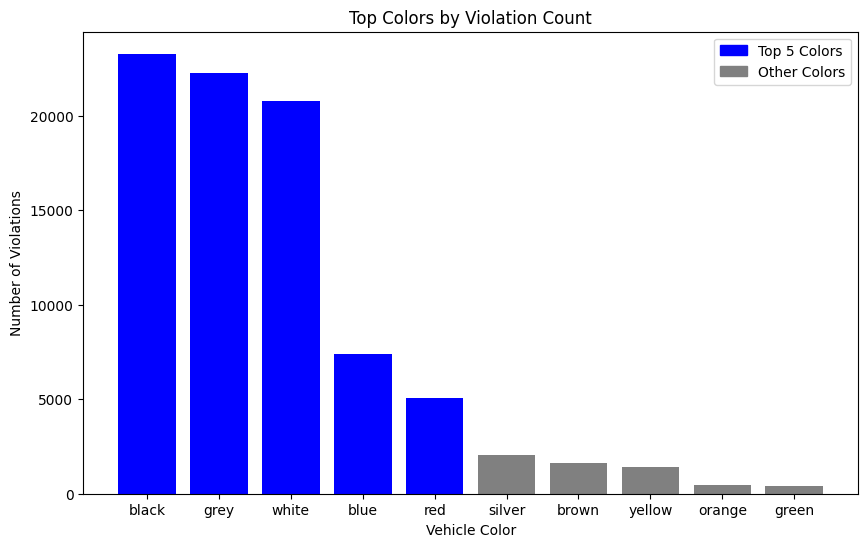

In [138]:
import matplotlib.pyplot as plt

top_colors_pd = top_colors.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_colors_pd['Vehicle Color'], top_colors_pd['count'])
plt.xlabel('Vehicle Color')
plt.ylabel('Number of Violations')
plt.title('Top Colors by Violation Count')

legend_elements = [plt.Rectangle((0,0), 1, 1, color='b', label='Top 5 Colors'),                   plt.Rectangle((0,0), 1, 1, color='gray', label='Other Colors')]
plt.legend(handles=legend_elements)


colors = ['b', 'b', 'b', 'b', 'b'] + ['gray'] * (len(top_colors_pd)-5)
for bar, color in zip(plt.gca().patches, colors):
    bar.set_facecolor(color)

plt.show()


In [139]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession


In [140]:
spark = SparkSession.builder \
    .appName("StringIndexer and OneHotEncoder Example") \
    .getOrCreate()


In [141]:
from pyspark.sql.functions import date_format

df_cleaned = df_cleaned.withColumn("Issue Date", date_format("Issue Date", "yyyy-MM-dd"))


In [142]:
categorical_columns = ['Registration State', 'Plate Type', 'Issue Date', 'Vehicle Body Type', 'Vehicle Color', 'Violation Time', 'Violation County']
numerical_columns = ['Street Code1', 'Street Code2', 'Street Code3', 'Violation Precinct']


In [143]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in categorical_columns]
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_onehot") for column in categorical_columns]


In [144]:
assembler = VectorAssembler(inputCols=[column+"_onehot" for column in categorical_columns] + numerical_columns, outputCol="features")


In [145]:
pipeline = Pipeline(stages=indexers + encoders + [assembler])
model = pipeline.fit(df_cleaned)

transformed_data = model.transform(df_cleaned)

selected_columns = transformed_data.select("features", "Violation Code")


selected_columns.show()
transformed_data.show()

df_cleaned.first()


+--------------------+--------------+
|            features|Violation Code|
+--------------------+--------------+
|(2866,[1,57,356,6...|            16|
|(2866,[3,57,357,6...|            98|
|(2866,[1,57,358,6...|            20|
|(2866,[0,57,359,6...|            21|
|(2866,[3,57,360,6...|            14|
|(2866,[0,57,361,6...|            14|
|(2866,[14,57,362,...|            98|
|(2866,[0,57,239,6...|            46|
|(2866,[0,57,239,6...|            24|
|(2866,[0,57,239,6...|            24|
|(2866,[7,57,270,6...|            21|
|(2866,[0,57,270,6...|            74|
|(2866,[13,57,363,...|            14|
|(2866,[0,59,364,6...|            46|
|(2866,[0,59,365,6...|            71|
|(2866,[0,59,271,6...|            14|
|(2866,[8,57,271,6...|            19|
|(2866,[1,57,366,6...|            14|
|(2866,[0,57,367,6...|            21|
|(2866,[0,57,368,6...|            40|
+--------------------+--------------+
only showing top 20 rows

+------------------+----------+------------+------------+-----

Row(Registration State='NJ', Plate Type='PAS', Street Code1=8730, Street Code2=5130, Street Code3=5280, Violation Code=16, Issue Date='1972-05-08', Vehicle Body Type='SDN', Vehicle Color='BK', Violation Precinct=72, Violation Time='0523P', Violation County='K')

In [78]:
train_data, test_data = transformed_data.randomSplit([0.6, 0.4], seed=222)



In [79]:
from pyspark.ml.classification import LogisticRegression

logr = LogisticRegression(featuresCol="features", labelCol="Violation Code")
logr_Model = logr.fit(train_data)



In [80]:
predictions = logr_Model.transform(test_data)



In [81]:

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [95]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="Violation Code", predictionCol="prediction", metricName="accuracy"
)

# Calculate the accuracy
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6788259485648291


In [90]:
from pyspark.sql import functions as F

from sklearn.metrics import confusion_matrix

y_true = predictions.select("Violation Code")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction").withColumn('pred_label', F.when(F.col('prediction') > 0.5, 1).otherwise(0))
y_pred = y_pred.select('pred_label').toPandas()

y_true = y_true.squeeze()
y_pred = y_pred.squeeze()

cnf_matrix = confusion_matrix(y_true, y_pred)
print(cnf_matrix)


[[    0     0     0 ...     0     0     0]
 [ 9993     0     0 ...     0     0     0]
 [10322     0     0 ...     0     0     0]
 ...
 [   60     0     0 ...     0     0     0]
 [  114     0     0 ...     0     0     0]
 [  428     0     0 ...     0     0     0]]


In [96]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator


precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="Violation Code", predictionCol="prediction", metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)


recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="Violation Code", predictionCol="prediction", metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)


f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="Violation Code", predictionCol="prediction", metricName="f1"
)
f1_score = f1_evaluator.evaluate(predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1_score}")

Precision: 0.6678919022350095
Recall: 0.678825948564829
F1-score: 0.6717782443652827
